# 🚦 Ablation Study Notebook – HOG/VGG16 + Classical ML (A/B/C)

This notebook runs three ablation directions on the LISA patch-classification pipeline:

- **A)** HOG *(cell, block)*
- **B)** HOG *orientations*
- **C)** Classifier variants *(Linear SVM vs RBF SVM vs SGD log_loss)*

It reuses your existing helpers in the repo:
- `dataset_lisa.py`
- `features_hog.py`

> **Before running:** set `DATASET_ROOT` to your local LISA dataset folder.


In [1]:
# =========================
# 0) Imports & Setup
# =========================
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve

from skimage.feature import hog
from skimage.color import rgb2gray

# --- dataset loader (from your repo) ---
from dataset_lisa import build_patch_dataset_from_box_csvs

# --- baseline HOG feature extractor (reference) ---
from features_hog import hog_batch  # baseline uses orientations=6, cell=4, block=2

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        tf.random.set_seed(seed)
    except Exception:
        pass

seed_everything(42)
print("TF:", tf.__version__)


TF: 2.20.0


In [2]:
# =========================
# 1) Config
# =========================
DATASET_ROOT = r"C:\Users\PC\.cache\kagglehub\datasets\mbornoe\lisa-traffic-light-dataset\versions\2"   # TODO: change this
RANDOM_SEED = 42
TEST_SIZE = 0.2
MAX_SAMPLES = 20000  # keep same as your original

LABEL_MAP = {0: "other", 1: "green", 2: "red", 3: "yellow"}


Building dataset from LISA annotations...
Patches: (20000, 64, 64, 3) Labels: (20000,)
Label distribution:
1 green : 8211
2 red : 11223
3 yellow : 566


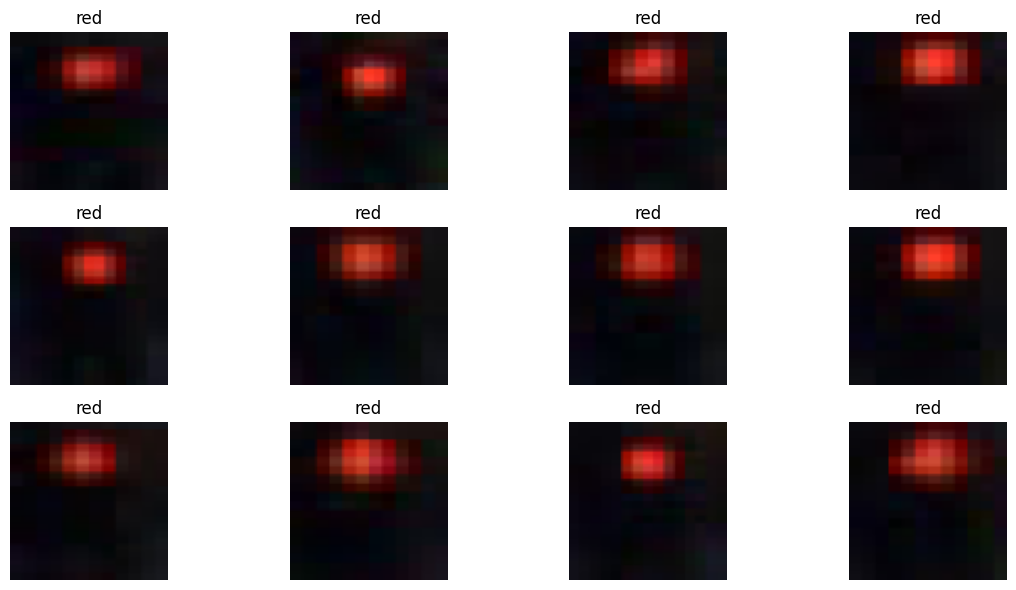

In [3]:
# =========================
# 2) Load Patch Dataset
# =========================
print("Building dataset from LISA annotations...")
X_patches, y = build_patch_dataset_from_box_csvs(DATASET_ROOT, max_samples=MAX_SAMPLES)

print("Patches:", X_patches.shape, "Labels:", y.shape)
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:")
for u, c in zip(unique, counts):
    print(int(u), LABEL_MAP.get(int(u), str(u)), ":", int(c))

# Quick visualize
nshow = min(12, len(X_patches))
plt.figure(figsize=(12, 6))
for i in range(nshow):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_patches[i])
    plt.title(LABEL_MAP[int(y[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [4]:
# =========================
# 3) Train/Test Split (Stratified)
# =========================
X_train_p, X_test_p, y_train, y_test = train_test_split(
    X_patches, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)
print("Train patches:", X_train_p.shape, "Test patches:", X_test_p.shape)


Train patches: (16000, 64, 64, 3) Test patches: (4000, 64, 64, 3)


In [5]:
# =========================
# 4) Feature Extractors (Parametric HOG + VGG16 freeze)
# =========================

def hog_batch_param(X_patches, cell=4, block=2, orientations=6):
    """Parametric HOG for ablations.
    - Input: RGB uint8 patches [N,64,64,3]
    - Output: float32 feature matrix [N,D]
    """
    feats = []
    for img in X_patches:
        gray = rgb2gray(img)  # [64,64] float
        feat = hog(
            gray,
            orientations=int(orientations),
            pixels_per_cell=(int(cell), int(cell)),
            cells_per_block=(int(block), int(block)),
            block_norm="L2-Hys",
            feature_vector=True
        )
        feats.append(feat.astype(np.float32))
    return np.vstack(feats)

def build_vgg16_feature_extractor():
    base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
    model = tf.keras.Sequential([base, tf.keras.layers.GlobalAveragePooling2D()])
    return model

def vgg16_features(model, X_patches_uint8, batch_size=64):
    X = X_patches_uint8.astype(np.float32)
    X = preprocess_input(X)
    feats = model.predict(X, batch_size=batch_size, verbose=1)
    return feats.astype(np.float32)

def plot_confmat(cm, class_names, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()


In [6]:
# =========================
# 5) Base Features (HOG baseline + VGG16 freeze)
# =========================

# HOG baseline from your features_hog.py (cell=4, block=2, orientations=6)
X_train_hog_base = hog_batch(X_train_p)
X_test_hog_base  = hog_batch(X_test_p)
print("HOG(base) train:", X_train_hog_base.shape, "test:", X_test_hog_base.shape)

print("Loading VGG16 feature extractor (freeze)...")
vgg_model = build_vgg16_feature_extractor()
X_train_vgg = vgg16_features(vgg_model, X_train_p, batch_size=64)
X_test_vgg  = vgg16_features(vgg_model, X_test_p, batch_size=64)
print("VGG train:", X_train_vgg.shape, "test:", X_test_vgg.shape)


HOG(base) train: (16000, 5400) test: (4000, 5400)
Loading VGG16 feature extractor (freeze)...
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step
VGG train: (16000, 512) test: (4000, 512)


In [7]:
# =========================
# 6) Evaluation Utilities
# =========================
def eval_classifier(clf, X_train, y_train, X_test, y_test, label_map=LABEL_MAP, title=""):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    acc = accuracy_score(y_test, pred)
    macro_f1 = f1_score(y_test, pred, average="macro")

    cm = confusion_matrix(y_test, pred)
    class_names = [label_map[i] for i in sorted(np.unique(np.concatenate([y_train, y_test])))]
    print("="*70)
    print(title)
    print("Accuracy:", acc)
    print("Macro-F1:", macro_f1)
    print("Confusion matrix:\n", cm)
    print(classification_report(y_test, pred, target_names=class_names))
    plot_confmat(cm, class_names, f"Confusion Matrix – {title}")

    return acc, macro_f1, cm

def make_rbf_svm(C=1.0):
    return make_pipeline(StandardScaler(), SVC(C=C, kernel="rbf", probability=False))

def make_linear_svm(C=1.0):
    return make_pipeline(StandardScaler(), LinearSVC(C=C))

def make_sgd_logloss(lr=1e-4, seed=RANDOM_SEED):
    return make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss="log_loss",
            learning_rate="constant",
            eta0=lr,
            max_iter=2000,
            tol=1e-3,
            random_state=seed
        )
    )



[A] Extracting HOG: cell=8, block=2, orientations=6
HOG(8,2) + RBF-SVM
Accuracy: 0.99775
Macro-F1: 0.9927643682940355
Confusion matrix:
 [[1639    3    0]
 [   2 2243    0]
 [   2    2  109]]
              precision    recall  f1-score   support

       green       1.00      1.00      1.00      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.96      0.98       113

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



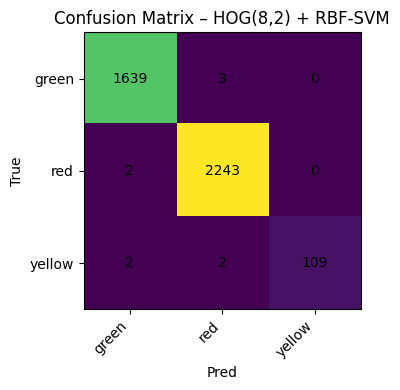


[A] Extracting HOG: cell=6, block=2, orientations=6
HOG(6,2) + RBF-SVM
Accuracy: 0.99675
Macro-F1: 0.9891529566508662
Confusion matrix:
 [[1638    4    0]
 [   3 2242    0]
 [   3    3  107]]
              precision    recall  f1-score   support

       green       1.00      1.00      1.00      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.95      0.97       113

    accuracy                           1.00      4000
   macro avg       1.00      0.98      0.99      4000
weighted avg       1.00      1.00      1.00      4000



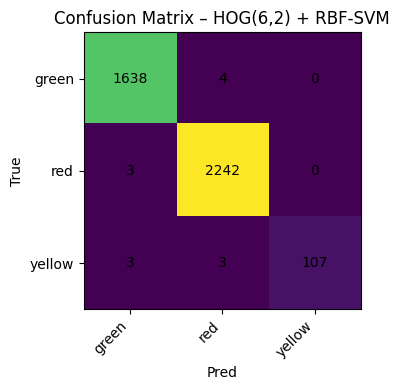


[A] Extracting HOG: cell=4, block=2, orientations=6
HOG(4,2) + RBF-SVM
Accuracy: 0.99525
Macro-F1: 0.9865837111852395
Confusion matrix:
 [[1636    6    0]
 [   6 2239    0]
 [   5    2  106]]
              precision    recall  f1-score   support

       green       0.99      1.00      0.99      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.94      0.97       113

    accuracy                           1.00      4000
   macro avg       1.00      0.98      0.99      4000
weighted avg       1.00      1.00      1.00      4000



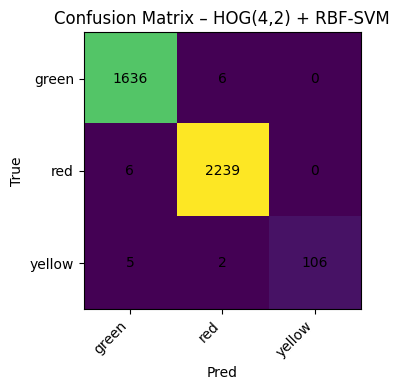


[A] Extracting HOG: cell=4, block=3, orientations=6
HOG(4,3) + RBF-SVM
Accuracy: 0.99625
Macro-F1: 0.9917100289245601
Confusion matrix:
 [[1635    7    0]
 [   4 2241    0]
 [   2    2  109]]
              precision    recall  f1-score   support

       green       1.00      1.00      1.00      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.96      0.98       113

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



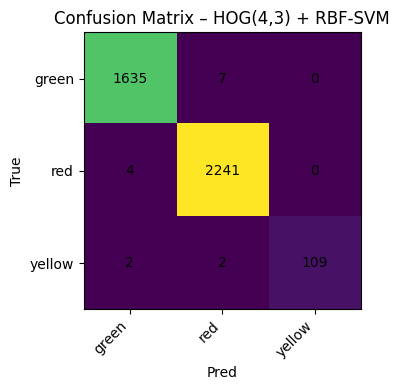


[A] Extracting HOG: cell=10, block=2, orientations=6
HOG(10,2) + RBF-SVM
Accuracy: 0.998
Macro-F1: 0.9943872152545673
Confusion matrix:
 [[1638    4    0]
 [   1 2244    0]
 [   1    2  110]]
              precision    recall  f1-score   support

       green       1.00      1.00      1.00      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.97      0.99       113

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



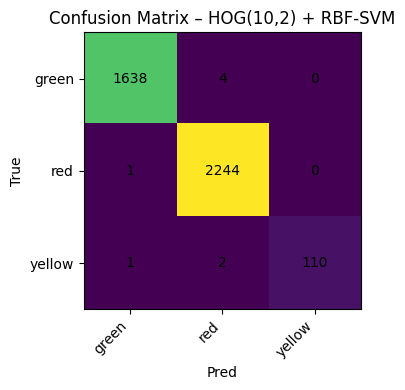


=== Ablation A Summary ===
cell block dim  acc  macro_f1
(8, 2, 1176, 0.99775, 0.9927643682940355)
(6, 2, 1944, 0.99675, 0.9891529566508662)
(4, 2, 5400, 0.99525, 0.9865837111852395)
(4, 3, 10584, 0.99625, 0.9917100289245601)
(10, 2, 600, 0.998, 0.9943872152545673)


In [8]:
# =========================
# A) Ablation – HOG (cell, block) with fixed orientations=6
# =========================
configs_A = [
    (8, 2),
    (6, 2),
    (4, 2),  # baseline
    (4, 3),
    (10, 2),
]

results_A = []
for cell, block in configs_A:
    print(f"\n[A] Extracting HOG: cell={cell}, block={block}, orientations=6")
    Xtr = hog_batch_param(X_train_p, cell=cell, block=block, orientations=6)
    Xte = hog_batch_param(X_test_p,  cell=cell, block=block, orientations=6)
    clf = make_rbf_svm(C=1.0)
    acc, mf1, _ = eval_classifier(clf, Xtr, y_train, Xte, y_test, title=f"HOG({cell},{block}) + RBF-SVM")
    results_A.append((cell, block, Xtr.shape[1], acc, mf1))

print("\n=== Ablation A Summary ===")
print("cell block dim  acc  macro_f1")
for r in results_A:
    print(r)



[B] Extracting HOG: cell=4, block=2, orientations=6
HOG ori=6 + RBF-SVM
Accuracy: 0.99525
Macro-F1: 0.9865837111852395
Confusion matrix:
 [[1636    6    0]
 [   6 2239    0]
 [   5    2  106]]
              precision    recall  f1-score   support

       green       0.99      1.00      0.99      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.94      0.97       113

    accuracy                           1.00      4000
   macro avg       1.00      0.98      0.99      4000
weighted avg       1.00      1.00      1.00      4000



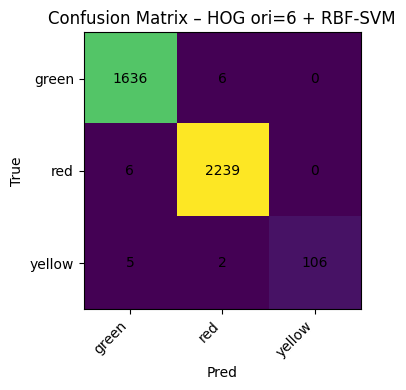


[B] Extracting HOG: cell=4, block=2, orientations=9
HOG ori=9 + RBF-SVM
Accuracy: 0.99525
Macro-F1: 0.9880717311728938
Confusion matrix:
 [[1634    8    0]
 [   5 2240    0]
 [   4    2  107]]
              precision    recall  f1-score   support

       green       0.99      1.00      0.99      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.95      0.97       113

    accuracy                           1.00      4000
   macro avg       1.00      0.98      0.99      4000
weighted avg       1.00      1.00      1.00      4000



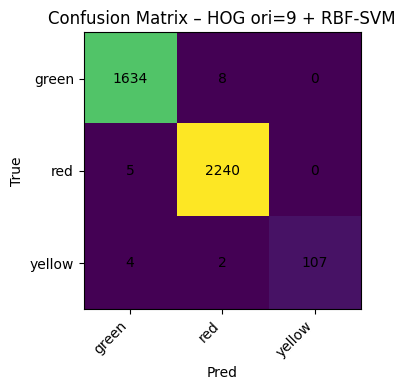


[B] Extracting HOG: cell=4, block=2, orientations=12
HOG ori=12 + RBF-SVM
Accuracy: 0.995
Macro-F1: 0.9849573735216524
Confusion matrix:
 [[1633    9    0]
 [   3 2242    0]
 [   4    4  105]]
              precision    recall  f1-score   support

       green       1.00      0.99      1.00      1642
         red       0.99      1.00      1.00      2245
      yellow       1.00      0.93      0.96       113

    accuracy                           0.99      4000
   macro avg       1.00      0.97      0.98      4000
weighted avg       1.00      0.99      0.99      4000



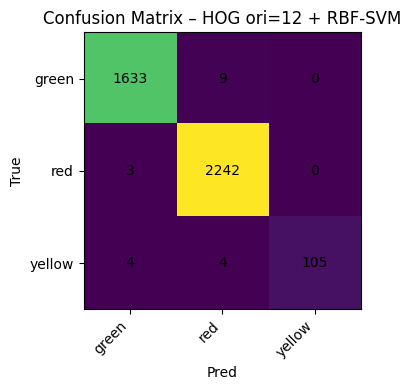


=== Ablation B Summary ===
ori dim  acc  macro_f1
(6, 5400, 0.99525, 0.9865837111852395)
(9, 8100, 0.99525, 0.9880717311728938)
(12, 10800, 0.995, 0.9849573735216524)


In [9]:
# =========================
# B) Ablation – HOG orientations with fixed cell=4, block=2
# =========================
oris_B = [6, 9, 12]

results_B = []
for ori in oris_B:
    print(f"\n[B] Extracting HOG: cell=4, block=2, orientations={ori}")
    Xtr = hog_batch_param(X_train_p, cell=4, block=2, orientations=ori)
    Xte = hog_batch_param(X_test_p,  cell=4, block=2, orientations=ori)
    clf = make_rbf_svm(C=1.0)
    acc, mf1, _ = eval_classifier(clf, Xtr, y_train, Xte, y_test, title=f"HOG ori={ori} + RBF-SVM")
    results_B.append((ori, Xtr.shape[1], acc, mf1))

print("\n=== Ablation B Summary ===")
print("ori dim  acc  macro_f1")
for r in results_B:
    print(r)



[C] Classifiers on HOG baseline


c:\Users\PC\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


HOG(base) + Linear-SVM
Accuracy: 0.9935
Macro-F1: 0.985544948478872
Confusion matrix:
 [[1633    8    1]
 [  11 2233    1]
 [   4    1  108]]
              precision    recall  f1-score   support

       green       0.99      0.99      0.99      1642
         red       1.00      0.99      1.00      2245
      yellow       0.98      0.96      0.97       113

    accuracy                           0.99      4000
   macro avg       0.99      0.98      0.99      4000
weighted avg       0.99      0.99      0.99      4000



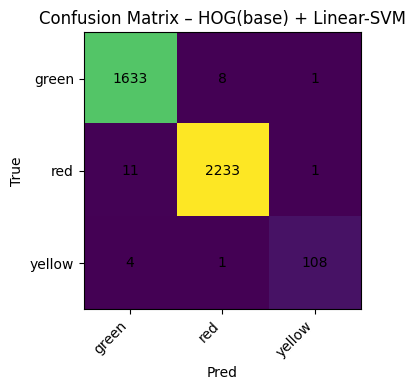

HOG(base) + RBF-SVM
Accuracy: 0.99525
Macro-F1: 0.9865837111852395
Confusion matrix:
 [[1636    6    0]
 [   6 2239    0]
 [   5    2  106]]
              precision    recall  f1-score   support

       green       0.99      1.00      0.99      1642
         red       1.00      1.00      1.00      2245
      yellow       1.00      0.94      0.97       113

    accuracy                           1.00      4000
   macro avg       1.00      0.98      0.99      4000
weighted avg       1.00      1.00      1.00      4000



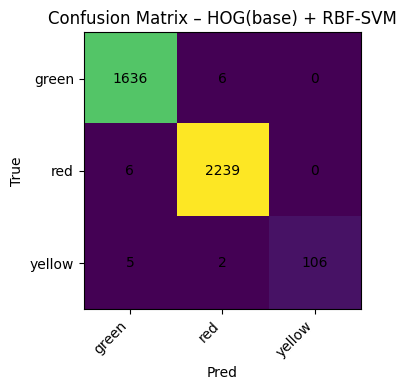

HOG(base) + SGD log_loss
Accuracy: 0.99475
Macro-F1: 0.9892375762356268
Confusion matrix:
 [[1636    5    1]
 [  11 2234    0]
 [   3    1  109]]
              precision    recall  f1-score   support

       green       0.99      1.00      0.99      1642
         red       1.00      1.00      1.00      2245
      yellow       0.99      0.96      0.98       113

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



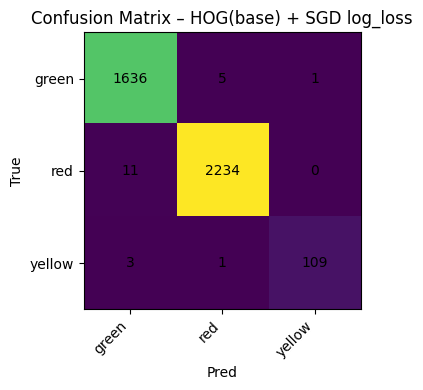


[C] Classifiers on VGG16(freeze)
VGG16(freeze) + Linear-SVM
Accuracy: 0.995
Macro-F1: 0.9853087957743595
Confusion matrix:
 [[1635    4    3]
 [   8 2236    1]
 [   4    0  109]]
              precision    recall  f1-score   support

       green       0.99      1.00      0.99      1642
         red       1.00      1.00      1.00      2245
      yellow       0.96      0.96      0.96       113

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       1.00      0.99      1.00      4000



c:\Users\PC\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


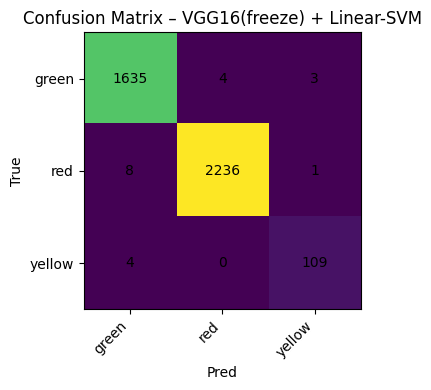

VGG16(freeze) + RBF-SVM
Accuracy: 0.98775
Macro-F1: 0.9720787717685336
Confusion matrix:
 [[1638    4    0]
 [  32 2213    0]
 [  12    1  100]]
              precision    recall  f1-score   support

       green       0.97      1.00      0.99      1642
         red       1.00      0.99      0.99      2245
      yellow       1.00      0.88      0.94       113

    accuracy                           0.99      4000
   macro avg       0.99      0.96      0.97      4000
weighted avg       0.99      0.99      0.99      4000



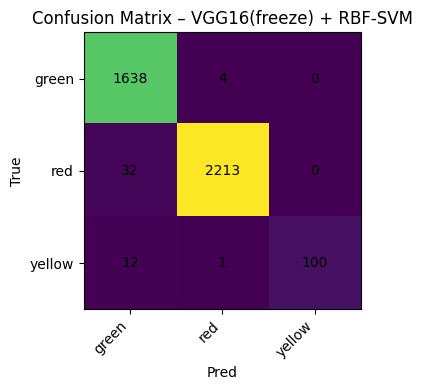

VGG16(freeze) + SGD log_loss
Accuracy: 0.9905
Macro-F1: 0.9691934743617366
Confusion matrix:
 [[1638    4    0]
 [  18 2227    0]
 [  14    2   97]]
              precision    recall  f1-score   support

       green       0.98      1.00      0.99      1642
         red       1.00      0.99      0.99      2245
      yellow       1.00      0.86      0.92       113

    accuracy                           0.99      4000
   macro avg       0.99      0.95      0.97      4000
weighted avg       0.99      0.99      0.99      4000



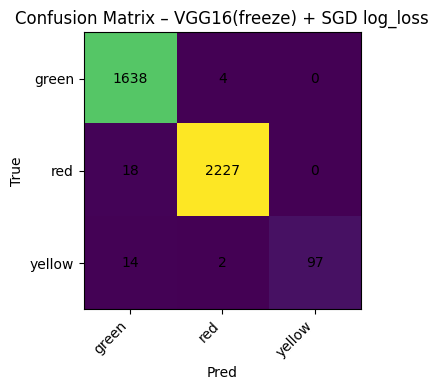


=== Ablation C Summary ===
(feature, classifier, acc, macro_f1)
('HOG(base)', 'Linear-SVM', 0.9935, 0.985544948478872)
('HOG(base)', 'RBF-SVM', 0.99525, 0.9865837111852395)
('HOG(base)', 'SGD log_loss', 0.99475, 0.9892375762356268)
('VGG16(freeze)', 'Linear-SVM', 0.995, 0.9853087957743595)
('VGG16(freeze)', 'RBF-SVM', 0.98775, 0.9720787717685336)
('VGG16(freeze)', 'SGD log_loss', 0.9905, 0.9691934743617366)


In [10]:
# =========================
# C) Ablation – Classifiers (keep features fixed)
#     - Linear SVM
#     - RBF SVM
#     - SGD (log_loss)
# Run for BOTH feature types:
#     - HOG baseline
#     - VGG16(freeze)
# =========================

def run_classifier_set(Xtr, Xte, feat_name):
    clfs = [
        ("Linear-SVM", make_linear_svm(C=1.0)),
        ("RBF-SVM",    make_rbf_svm(C=1.0)),
        ("SGD log_loss", make_sgd_logloss(lr=1e-4)),
    ]
    rows = []
    for name, clf in clfs:
        acc, mf1, _ = eval_classifier(clf, Xtr, y_train, Xte, y_test, title=f"{feat_name} + {name}")
        rows.append((feat_name, name, acc, mf1))
    return rows

results_C = []
print("\n[C] Classifiers on HOG baseline")
results_C += run_classifier_set(X_train_hog_base, X_test_hog_base, "HOG(base)")

print("\n[C] Classifiers on VGG16(freeze)")
results_C += run_classifier_set(X_train_vgg, X_test_vgg, "VGG16(freeze)")

print("\n=== Ablation C Summary ===")
print("(feature, classifier, acc, macro_f1)")
for r in results_C:
    print(r)


In [11]:
# =========================
# Optional: Learning Curve helper for any (feature matrix, model)
# =========================
def plot_learning_curve_generic(X, y, title, estimator):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=np.linspace(0.1, 1.0, 8),
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean   = val_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_std    = val_scores.std(axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, marker="o", label="Train acc")
    plt.plot(train_sizes, val_mean, marker="o", label="Val acc")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.title(title)
    plt.xlabel("Number of training samples")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

# Examples (uncomment):
# plot_learning_curve_generic(X_train_hog_base, y_train, "LC – HOG(base) + RBF-SVM", make_rbf_svm())
# plot_learning_curve_generic(X_train_vgg, y_train, "LC – VGG16(freeze) + RBF-SVM", make_rbf_svm())


## Notes for your slides

- Report **Accuracy + Macro-F1** (Macro-F1 matters because Yellow is rare).
- For Ablation **A/B**, keep the classifier fixed (RBF-SVM) so differences reflect **feature choice**, not classifier.
- For Ablation **C**, keep features fixed so differences reflect **classifier choice**.
